# Spotify 1 Million Tracks - Tratamento e Modelação

### Importe das Bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline


# Para visualizar os valores com cinco casas decimais
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Tratamento dos Dados

Carregar o dataset, previamente analisado

In [4]:
data = pd.read_csv('dataset/spotify_data.csv')

Eliminar coluns irrelevantes:
ids e nomes das músicas

In [5]:
# Drop Id and Track Id columns
data.drop(['Unnamed: 0', 'track_id', 'track_name'], axis=1, inplace=True, errors='ignore')

Remover outliers por género

In [6]:
"""q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']
q1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']

data_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))
data_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))
data_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']

#data_aux
# Verificar os outliers
no_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]
no_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)
no_outliers"""

"q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\nq1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\n\ndata_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))\ndata_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))\ndata_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']\n\n#data_aux\n# Verificar os outliers\nno_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]\nno_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)\nno_outliers"

Converter valores categóricos para valores contínuos

In [7]:
data_non_categorical = data.copy()
lb_make = LabelEncoder()
data_non_categorical['artist_name'] = lb_make.fit_transform(data_non_categorical['artist_name'])
data_non_categorical['genre'] = lb_make.fit_transform(data_non_categorical['genre'])
data_non_categorical

,artist_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,26235,68,2012,0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3
1,26235,50,2012,0,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4
2,28122,57,2012,0,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4
3,7629,58,2012,0,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4
4,3014,54,2012,0,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,40236,4,2011,81,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3
1159760,40236,3,2011,81,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4
1159761,2723,2,2011,81,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4
1159762,43073,0,2011,81,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3


## Modelação 

Partição dos Dados entre dados de treino e teste

In [8]:
X = data_non_categorical.drop('popularity', axis=1)
y = data_non_categorical['popularity']
print(X)
print(y)

         artist_name  year  genre  danceability  energy  key  loudness  mode  \
0              26235  2012      0         0.483   0.303    4   -10.058     1   
1              26235  2012      0         0.572   0.454    3   -10.286     1   
2              28122  2012      0         0.409   0.234    3   -13.711     1   
3               7629  2012      0         0.392   0.251   10    -9.845     1   
4               3014  2012      0         0.430   0.791    6    -5.419     0   
...              ...   ...    ...           ...     ...  ...       ...   ...   
1159759        40236  2011     81         0.373   0.742   10    -6.453     0   
1159760        40236  2011     81         0.516   0.675    7    -7.588     0   
1159761         2723  2011     81         0.491   0.440    5    -8.512     1   
1159762        43073  2011     81         0.480   0.405    0   -13.343     1   
1159763        38141  2011     81         0.782   0.861    1    -7.292     0   

         speechiness  acousticness  ins

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

### Problema de regressão

#### Modelo de Regressão Linear

Criação do modelo

In [10]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Previsões do modelo

In [11]:
predictions = lm.predict(X_test)

Gráfico de previsão vs valor real
- X: valor real
- Y: previsão

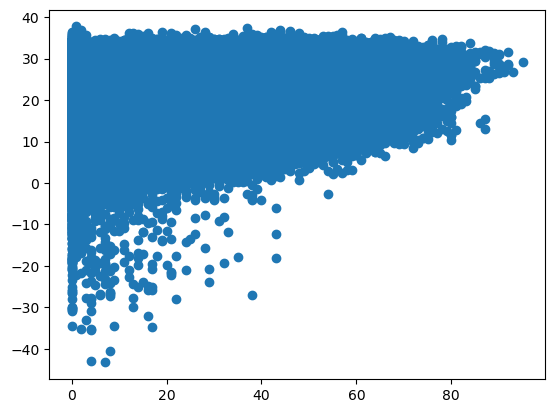

In [12]:
plt.scatter(y_test, predictions)

Valor máximo da previsão

In [13]:
predictions.max()

37.7560383948005

Comparar os valores previstos com os reais

In [14]:
pd.merge(pd.DataFrame(y_test), pd.DataFrame(predictions), left_index=True, right_index=True)    

,popularity,0
223562,2,26.508848
311704,35,22.774238
181186,51,19.805906
282310,25,12.724049
460212,9,10.244328
...,...,...
204448,1,13.075345
177999,27,14.801582
45776,5,17.850261
239854,10,28.703465


Avaliação do Modelo

In [15]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 11.529476982153563
MSE: 206.5359345828317
RMSE: 14.371358132856884


### Problema de Classificação

Uma outra forma de resolver este problema de previsão da popularidade de uma música consiste em transformar a feature 'popularity', target do nosso problema, numa feature discreta, dividindo a gama de valores contínuos (0 a 100) numa série de bins, ou seja intervalos de popularidade. Por exemplo, para 10 bins, o objetivo passaria a ser o de prever qual o nível de popularidade de uma música (Nível 0 - 0..10, Nível 1 - 10..20, etc)

Vamos então transformar a feature 'popularity' numa feature discreta, recorrendo à funcionalidade KBinsDiscretizer do módulo Sci-kit learn.
Este módulo permite realizar binning de duas estratégias diferentes:

- ‘uniform’: All bins in each feature have identical widths.

- ‘quantile’: All bins in each feature have the same number of points.

In [16]:
estimator = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['popularity_binned'] = estimator.fit_transform(data[['popularity']])
data['popularity_binned'].value_counts()
data.drop(['popularity'], axis=1)

,artist_name,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_binned
0,Jason Mraz,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3,4.0
1,Jason Mraz,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4,4.0
2,Joshua Hyslop,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4,4.0
3,Boyce Avenue,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4,4.0
4,Andrew Belle,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,Nicola Conte,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3,1.0
1159760,Nicola Conte,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4,1.0
1159761,Amon Tobin,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4,0.0
1159762,Peace Orchestra,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3,0.0


### Modelo de Árvores de Decisão

Vamos agora criar um modelo de árvores de decisão para prever o intervalo de popularidade de uma música.

In [17]:
classifier = DecisionTreeClassifier(random_state=2023)

Before training the model, we must assure that all features are non categorical.

In [18]:
continous_features = data.copy()
lb_make = LabelEncoder()
continous_features['artist_name'] = lb_make.fit_transform(continous_features['artist_name'])
continous_features['genre'] = lb_make.fit_transform(continous_features['genre'])
continous_features

,artist_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_binned
0,26235,68,2012,0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3,4.0
1,26235,50,2012,0,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4,4.0
2,28122,57,2012,0,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4,4.0
3,7629,58,2012,0,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4,4.0
4,3014,54,2012,0,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,40236,4,2011,81,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3,1.0
1159760,40236,3,2011,81,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4,1.0
1159761,2723,2,2011,81,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4,0.0
1159762,43073,0,2011,81,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3,0.0


In [19]:
X_dt = continous_features.drop(['popularity', 'popularity_binned'], axis=1)
y_dt = continous_features['popularity_binned'].to_frame()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.25, random_state=101)

In [21]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2023)

In [ ]:
d_tree_predictions = classifier.predict(X_test)
d_tree_predictions

In [ ]:
accuracy_score(y_test, d_tree_predictions)